# Classifying Names with a Recurrent Neural Network

Author: Christoph Schauer <br/>
Date: 05/05/2019


## Introduction

In this notebook, a simple Recurrent Neural Network (RNN) with a GRU plus a fully connected layer is trained to classify names according to their language using a dataset consisting of about 20,000 names in 18 languages. After training for 40 epochs, the network achieves an accuracy of around 95%, although it does have troubles differentiating between names of in this regard similar languages (Scottish and English, Spanish and Portuguese, Chinese and Vietnamese). The notebook also includes code for a standard RNN and a RNN with LSTM as well as a predictor function running on user input.

The code in this notebook is an adaption of the tutorial [Classifying Names with a Character-Level RNN](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) by Sean Robertson from the official PyTorch website. I try to follow the naming conventions used there for the most part. The primary changes are:
* Converting the text files containing the names into a quasi-tabular format 
* Replacing the custom 1-by-1 data loader with a standard PyTorch batch data loader using sequence padding
* Replacing the custom RRNN code with a network using PyTorch's nn.RNN() module plus a fully connected layer
* Adding classes to build RNNs with GRU and LSTM
* Additional and more informative printouts

I made these changes to bring the workflow more more in line with people learning PyTorch - including myself - will have seen in other basic tutorials and to make it easier to use it as stepping stone for working with other text datasets.

Small portions of code are also based on [PyTorch Tutorials: Recurrent Neural Network](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/02-intermediate/recurrent_neural_network/main.py) by Yunjey Choi.

## Table of contents

* Introduction
* Load required libraries
* Data preprocessing
* Sequence padding
* Create custom dataset object
* Network architectures: RNN, LSTM & GRU
* Training the network
* Model evaluation
* Saving and loading a network

## To be done:

* Use negative log-likelihood loss as criterion
* Fix xticks errors in training progress visualization
* Save model state dictionary
* Add a predictor function using user input using an imported module and a saved state dict of a trained model
* Update CustomDataset() class to accept different data formats 
* Add embeddings
* Add sequence packing

## Required packages

In [1]:
# Small utility packages
import requests
import zipfile
import os
import string
import unicodedata
import time

# NumPy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

## Data Preprocessing

Steps of the data preprocessing pipeline:

* Download data
* Create feature and label lists from files
* Create "vocabulary" of letters
* Strip accents
* Find the index of a letter
* Convert names to tensors by one-hot encoding
* Pad sequences

### Download and unzip data

The data can also be downloaded manually from this URL: https://download.pytorch.org/tutorial/data.zip

In [2]:
# Download zipped data to working directory
fileurl = "https://download.pytorch.org/tutorial/data.zip"
r = requests.get(fileurl)
open("data.zip", 'wb').write(r.content)

# Extract data to /data folder
import zipfile
with zipfile.ZipFile("data.zip","r") as zip_ref:
    zip_ref.extractall(".");

### Create text and category lists (names and languages)

The original data has one text file with names per language. The code below loads the text files and converts them into a quasi-tabular format - two lists of equal length for text and labels - to replicate a tabular data format with the features and labels of one observation being in the same line.

In [3]:
# Data directory of downloaded files 
filepath = "data/names/"

# Initialize lists for all names and the corresponding languages 
line_list = []
category_list = []

# Store categories 
all_categories = []

# Loop over all files in the directory and read them
for filename in os.listdir(filepath):   
    lines = open(filepath+filename, encoding = "utf-8").read().strip().split("\n")
    line_list += lines
    category = filename.split(".")[0]
    all_categories.append(category)
    categories = [category]*len(lines)
    category_list += categories

n_categories = len(all_categories)

# Check data 
print("Length of line/category lists: {}/{}".format(len(line_list), len(category_list)))
print("Number of categories:", n_categories)
print("Categories:", all_categories)
print("First 5 names:", line_list[0:5])

Length of line/category lists: 20074/20074
Number of categories: 18
Categories: ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
First 5 names: ['Khoury', 'Nahas', 'Daher', 'Gerges', 'Nazari']


In [4]:
# Names per language: Unbalanced dataset
unique, counts = np.unique(category_list, return_counts=True)
print("Names per language in training data:\n", dict(zip(unique, counts)))

Names per language in training data:
 {'Arabic': 2000, 'Chinese': 268, 'Czech': 519, 'Dutch': 297, 'English': 3668, 'French': 277, 'German': 724, 'Greek': 203, 'Irish': 232, 'Italian': 709, 'Japanese': 991, 'Korean': 94, 'Polish': 139, 'Portuguese': 74, 'Russian': 9408, 'Scottish': 100, 'Spanish': 298, 'Vietnamese': 73}


### Converting names to tensors

The code below converts each name in the line_list to a tensor: Each letter is converted to a one-dimensional tensor of length 58 - the number of letters in the "vocabulary" - with a 1 for the index of this letter in the vocabulary and zeroes otherwise. This is similar to one-hot encoding of categorical features for classic machine learning models. Each name is then a tensor of dimensions "letters per name" times 1 times "letters in alphabet" - or, generally speaking, sequence length times 1 times vocabulary size (if you tokenize a text by words, the vocabulary would be a list of words, hence my use of this term here).

In [5]:
# Create "vocabulary" of letter

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters)

print("Vocabulary:", all_letters)
print("Vocabulary size:", n_letters)

Vocabulary: abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'-
Vocabulary size: 58


In [6]:
# Function to strip accents from letters

def unicode_to_ascii(s):
    return "".join(
        c for c in unicodedata.normalize("NFD", s)
        if unicodedata.category(c) != "Mn"
        and c in all_letters
    )

# Example
print("Example: Ślusàrski >>>", unicode_to_ascii("Ślusàrski"))

Example: Ślusàrski >>> Slusarski


In [7]:
# Function to find letter index from all_letters "vocabulary"

def letter_to_index(letter):
    return all_letters.find(letter)

# Example
print("Index of letter 'c':", all_letters.find("c"))  

Index of letter 'c': 2


In [8]:
# Function to convert each line = each name into a one-hot tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for i, letter in enumerate(line):
        tensor[i][0][letter_to_index(letter)] = 1
    return tensor

# Example
print("Example name: Kim")
print("Tensor size:", line_to_tensor("Kim").size())
print("Tensorized name:\n", line_to_tensor("Kim"))

Example name: Kim
Tensor size: torch.Size([3, 1, 58])
Tensorized name:
 tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])


In [9]:
# Combine the functions above to the list of names into a list of tensorized names

line_list_clean = [unicode_to_ascii(line) for line in line_list]
line_list_tensorized = [line_to_tensor(line) for line in line_list_clean] 

# Check data
print("Length of line list:", len(line_list_tensorized))
print("Example name:", line_list[-1])
print(line_list_tensorized[-1])

Length of line list: 20074
Example name: Vuu
tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]])


## Sequence padding

The names in the dataset have different lengths, just like sentences have a different number of words. In an RNN, all sequences in one batch need to be of the same length. The simplest way to achieve this is to pad each name tensor with tensors of zeroes to the length of the longest name in the dataset. This is not the most memory-efficient way to handle this problem. This isn't an issue here with this small, simple dataset, but when working with large datasets with "real" text with wildly different sequence lengths (news articles, for example), packing (in addition to padding) is recommended; see https://pytorch.org/docs/stable/nn.html#torch.nn.utils.rnn.PackedSequence.

In [10]:
sequence_length = len(max(line_list, key=len))

print("Longest name:", max(line_list, key=len))
print("Maximum sequence length:", sequence_length)

Longest name: Shirinsky-Shikhmatov
Maximum sequence length: 20


In [11]:
# Pad sequences - automatically converts the data to a tensor
line_tensor = pad_sequence(line_list_tensorized)

# Transpose tensor to the correct format: Number of observations, 1, sequence length, features
line_tensor_permuted = line_tensor.permute(1,2,0,3)

print("Original shape:", line_tensor.size())
print("Permuted shape:", line_tensor_permuted.size())

Original shape: torch.Size([20, 20074, 1, 58])
Permuted shape: torch.Size([20074, 1, 20, 58])


## Create custom dataset object

### Convert data to arrays

The class CustomDataset() converts an array of features and an array of labels into a data object from which PyTorch's data loaders load data into the network for training. You can make do without creating such an object, but doing so aligns this workflow with what many who started their PyTorch journey with one of the datasets that come with PyTorch (like MNIST) will be familiar with.

As the CustomDataset() class requires arrays as inputs, the tensor X holding the features has to be converted back into a NumPy array first.

In [12]:
# Convert feature tensor to array
X = line_tensor_permuted.numpy()

# Map languages to integer labels
category_dict = dict(zip(all_categories, range(n_categories)))

# Convert all languages in the category list to an array of labels
category_list_numeric = [category_dict.get(i) for i in category_list]
y = np.array(category_list_numeric)

print("Category dictionary:", category_dict)
print("Length of category array:", y.shape)

Category dictionary: {'Arabic': 0, 'Chinese': 1, 'Czech': 2, 'Dutch': 3, 'English': 4, 'French': 5, 'German': 6, 'Greek': 7, 'Irish': 8, 'Italian': 9, 'Japanese': 10, 'Korean': 11, 'Polish': 12, 'Portuguese': 13, 'Russian': 14, 'Scottish': 15, 'Spanish': 16, 'Vietnamese': 17}
Length of category array: (20074,)


In [13]:
class CustomDataset():
    '''Creates a custom dataset from numpy arrays of features and labels 
    for feeding into PyTorch dataloaders '''
    def __init__(self, features, labels):
        self.features = torch.from_numpy(features)
        self.labels = torch.from_numpy(labels).type(torch.LongTensor)
        self.len = len(features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.len

In [14]:
# Instantiate objects for train and test sets

data_train = CustomDataset(features=X, labels=y)
data_test = CustomDataset(features=X, labels=y)

## Data loaders

In [15]:
# Set batch size
batch_size = 100

# Data loaders 
trainloader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
testloader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False)

# Test data loaders
print("Lines in training data:", len(trainloader.dataset))
print("Training batches:", len(trainloader))
print("Batch size:", batch_size)

Lines in training data: 20074
Training batches: 201
Batch size: 100


In [16]:
# Test data loaders: Load a batch
dataiter = iter(trainloader)
names, labels = dataiter.next()
print("Batch of tensorized names:", names.size())
print("Batch of labels:", labels.size())

Batch of tensorized names: torch.Size([100, 1, 20, 58])
Batch of labels: torch.Size([100])


# Model architecture

TO DO: Add a brief description of the RNN architecture used here and differences between standard RNN, GRU and LSTM model.

### Device configuration

In [29]:
# Train the network on a GPU if a cuda-GPU is available

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


### Network architecture hyperparameters

These parameters are the same for the standard RNN, the RNN with GRU and the one with LSTM.

In [18]:
# Network architecture hyperparameters

input_size = n_letters   # size of vocabulary
hidden_size = 128
num_layers = 2
num_classes = n_categories

### Standard Recurrent Neural Network

In [19]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)   # RNN
        self.fc = nn.Linear(hidden_size, num_classes)  
        
    def forward(self, x):
        # Set initial hidden and cell states - RNN
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

### RNN with GRU

In [20]:
class RNN_GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)   # GRU
        self.fc = nn.Linear(hidden_size, num_classes)  
        
    def forward(self, x):
        # Set initial hidden and cell states - GRU
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        # Forward propagate RNN
        out, _ = self.gru(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

### RNN with LSTM

In [21]:
class RNN_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN_LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)   # LSTM
        self.fc = nn.Linear(hidden_size, num_classes)  
        
    def forward(self, x):
        # Set initial hidden and cell states - LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate RNN
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

## Training the network

I'm training and evaluating an RNN with a GRU here. A network with LSTM achieves similar accuracy. A RNN with neither LSTM nor GRU, however, has troubles learning. For trying out one of the other two models, just use a model of a different class.

### RNN with GRU

In [22]:
# Instantiate model
model = RNN_GRU(input_size, hidden_size, num_layers, num_classes) 

# Send model to device
model.to(device)

# Traing hyper-parameters
sequence_length = sequence_length   # length of padded tensors
num_epochs = 40
learning_rate = 0.001

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Print out training progress every {print_every} batches
print_every = 200 

In [23]:
# Code for printouts and visualizations ----------------

start_time = time.time()

print("Start of traing -- Device: {} -- Epochs: {} -- Batches: {} -- Batch size: {}"
      .format(device, num_epochs, len(trainloader), batch_size))

# Initiate variables and lists for training progress printouts and visualizations
running_loss = 0
running_total = 0
running_correct = 0
loss_list = [] 
loss_list_print_every = [] 


# Code for actual training -----------------------------

# Set model to training mode
model.train()

# Train the model
for epoch in range(num_epochs):
    for i, (lines, labels) in enumerate(trainloader):
        
        # Send data to GPU
        lines, labels = lines.to(device), labels.to(device)
        
        # Reshape lines batch
        lines = lines.reshape(-1, sequence_length, input_size)
        
        # Forward and backward pass
        output = model(lines)
        loss = criterion(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
# Code for printouts and visualizations ----------------

        # Store running loss, total, correct
        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        running_total += labels.size(0)
        running_correct += (predicted == labels).sum().item()       
        loss_list.append(loss.item())

        # Print out  average training loss and accuracy every {print_every} batches
        if (i+1) % print_every == 0:         
            print("Epoch: {}/{} -- Batches: {}/{} -- Training loss: {:.3f} -- Training accuracy: {:.3f}"
                  .format(epoch+1, num_epochs, i+1, len(trainloader), 
                          running_loss/print_every, running_correct/running_total))
            
            # Store running loss in list
            loss_list_print_every.append(running_loss/print_every)
            
            # Reset running loss and accuracy
            running_loss = 0
            running_total = 0
            running_correct = 0
            
print("Training complete. Total training time: {:.1f} seconds".format(time.time() - start_time))

Start of traing -- Device: cuda -- Epochs: 40 -- Batches: 201 -- Batch size: 100
Epoch: 1/40 -- Batches: 200/201 -- Training loss: 1.743 -- Training accuracy: 0.497
Epoch: 2/40 -- Batches: 200/201 -- Training loss: 1.424 -- Training accuracy: 0.577
Epoch: 3/40 -- Batches: 200/201 -- Training loss: 1.202 -- Training accuracy: 0.658
Epoch: 4/40 -- Batches: 200/201 -- Training loss: 1.083 -- Training accuracy: 0.685
Epoch: 5/40 -- Batches: 200/201 -- Training loss: 0.990 -- Training accuracy: 0.709
Epoch: 6/40 -- Batches: 200/201 -- Training loss: 0.917 -- Training accuracy: 0.728
Epoch: 7/40 -- Batches: 200/201 -- Training loss: 0.843 -- Training accuracy: 0.750
Epoch: 8/40 -- Batches: 200/201 -- Training loss: 0.780 -- Training accuracy: 0.767
Epoch: 9/40 -- Batches: 200/201 -- Training loss: 0.720 -- Training accuracy: 0.787
Epoch: 10/40 -- Batches: 200/201 -- Training loss: 0.671 -- Training accuracy: 0.800
Epoch: 11/40 -- Batches: 200/201 -- Training loss: 0.633 -- Training accuracy:

### Training progress visualization

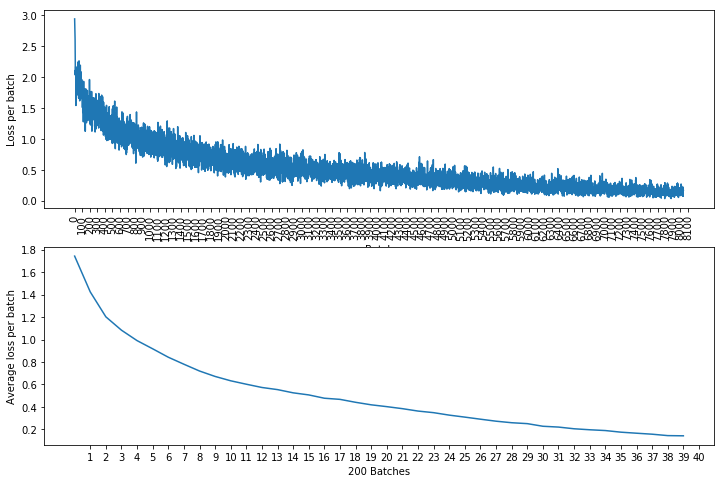

In [24]:
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
xticks = np.arange(0, len(loss_list)+100, 100)
plt.plot(loss_list)
plt.xticks(xticks)
plt.xticks(rotation=90)
plt.xlabel("Batch")
plt.ylabel("Loss per batch")

plt.subplot(2,1,2)
xticks = np.arange(1, len(loss_list_print_every)+1, 1)
plt.plot(loss_list_print_every)
plt.xticks(xticks)
plt.xlabel(str(print_every)+" Batches")
plt.ylabel("Average loss per batch")

plt.show()

## Model evaluation

In [25]:
# Initialize variables and arrays to store loss and true and predicted labels
running_loss = 0
labels_true = np.array([], dtype=int)
labels_pred = np.array([], dtype=int)

# Set model to evaluation mode
model.eval()

with torch.no_grad():   # Deactive gradient calculations   
    for i, (lines, labels) in enumerate(testloader):
        lines, labels = lines.to(device), labels.to(device)
        lines = lines.reshape(-1, sequence_length, input_size).to(device)
        
        # Forward pass
        output = model(lines)
        loss = criterion(output, labels)

        running_loss += loss.item()
        _, predicted = torch.max(output.data, 1)      

        # calculate accuracy - not really required when true and predicted labels are stored anyway
        labels_true = np.append(labels_true, labels.cpu().numpy())
        labels_pred = np.append(labels_pred, predicted.cpu().numpy())

        
test_accuracy = np.equal(labels_pred, labels_true).mean()         
        
print("Evaluating network on {} images in test set -- Test loss: {:.3f} -- Test accuracy: {:.3f}"
      .format(len(testloader.dataset), running_loss/len(testloader), test_accuracy))

Evaluating network on 20074 images in test set -- Test loss: 0.128 -- Test accuracy: 0.956


### Accuracy per category

In [26]:
# Initialize matrix of zeroes
cm = np.zeros((num_classes, num_classes))

# Build confusion matrix
for i in range(len(labels_true)):
    cm[labels_true[i]][labels_pred[i]] +=1

# Normalize values in confusion matrix
for i in range(num_classes):
    cm[i] = cm[i] / cm[i].sum()

print("Accuracy by category:")
acc_dict = dict(zip(all_categories, [round(i, 2) for i in (cm.diagonal())]))
for i in range(len(acc_dict)):
    print(list(acc_dict.keys())[i], ":", list(acc_dict.values())[i])

Accuracy by category:
Arabic : 1.0
Chinese : 0.94
Czech : 0.86
Dutch : 0.86
English : 0.95
French : 0.79
German : 0.91
Greek : 1.0
Irish : 0.78
Italian : 0.94
Japanese : 0.99
Korean : 0.81
Polish : 0.88
Portuguese : 0.49
Russian : 0.99
Scottish : 0.04
Spanish : 0.8
Vietnamese : 0.4


### Visualize confusion matrix

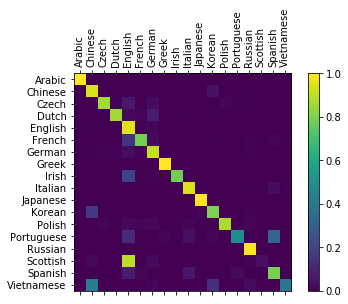

In [27]:
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

The model has troubles differentiating between names of similar languages (Scottish and English, Spanish and Portuguese, Vietnamese and Chinese).

## Predictor Function

In [28]:
# TBD